In [1]:
from whitening_model import *
import pandas as pd
from utils import *
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt
from trading_model import *
from AR_model import *
import itertools
sns.set()
sns.set(font_scale=1.5)
import scipy

%load_ext autoreload
%autoreload 2

In [46]:
FF = pd.read_csv('FF_data.CSV')
FF = FF.rename(columns={'Unnamed: 0': "date"})
FF.index = pd.to_datetime(FF['date'].astype(str), format='%Y/%m/%d')
FF = FF.drop(['date', 'RF'], axis=1)
FF = FF/100
# FF = FF.loc['1985-01-01':'2000-01-01']
FF = FF.loc['2000-01-01':]


train_frac = 0.35
val_frac = 0.35
train_len = int(train_frac*FF.shape[0])
val_len = int(val_frac*FF.shape[0])
data = FF.values
dates = FF.index

# EWMA benchmark

In [11]:
T_half = 50

beta = np.exp(-np.log(2)/T_half)
r_ewmas = get_EWMAs(data, beta)
r_hat_ewmas = r_ewmas[train_len+val_len:-1]
data_test_ewma = data[train_len+val_len+1:]
dates_ewma = dates[train_len+val_len:-1]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_ewmas.flatten(), data_test_ewma.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Correct sign: {np.mean(np.sign(r_hat_ewmas) == np.sign(data_test_ewma)):.2%}")
print(f"Observed positive returns: {np.mean(data_test_ewma>0):.2%}")
print(f"Excess sign: {np.mean(np.sign(r_hat_ewmas) == np.sign(data_test_ewma))-np.mean(data_test_ewma>0):.2%}")

Correlation: -0.01%
Beta:  -0.0015
Correct sign: 50.59%
Observed positive returns: 49.57%
Excess sign: 1.01%


# No standardization

In [34]:
### Get data in lagged format
memory_nw = 1
alpha_nw = 1e6

pred_horizon = 0
weighted = True

update_period = int(252/2)

### Define features
sigmas = np.std(data[:train_len+val_len], axis=0).reshape(1,-1)
hi = get_hi(data, sigmas)
lo = get_lo(data, sigmas)
pos = get_pos(data)
neg = get_neg(data)

ma2 = moving_average(data, 2)
sigmas2 = np.std(ma2[:train_len+val_len], axis=0).reshape(1,-1)
hi2 = get_hi(ma2, sigmas2)
lo2 = get_lo(ma2, sigmas2)
pos2 = get_pos(ma2)
neg2 = get_neg(ma2)

ma4 = moving_average(data, 4)
sigmas4 = np.std(ma4[:train_len+val_len], axis=0).reshape(1,-1)
hi4 = get_hi(ma4, sigmas4)
lo4 = get_lo(ma4, sigmas4)
pos4 = get_pos(ma4)
neg4 = get_neg(ma4)

ma8 = moving_average(data, 8)
sigmas8 = np.std(ma8[:train_len+val_len], axis=0).reshape(1,-1)
hi8 = get_hi(ma8, sigmas8)
lo8 = get_lo(ma8, sigmas8)
pos8 = get_pos(ma8)
neg8 = get_neg(ma8)

ma16 = moving_average(data, 16)
sigmas16 = np.std(ma16[:train_len+val_len], axis=0).reshape(1,-1)
hi16 = get_hi(ma16, sigmas16)
lo16 = get_lo(ma16, sigmas16)
pos16 = get_pos(ma16)
neg16 = get_neg(ma16)

ma32 = moving_average(data, 32)
sigmas32 = np.std(ma32[:train_len+val_len], axis=0).reshape(1,-1)
hi32 = get_hi(ma32, sigmas32)
lo32 = get_lo(ma32, sigmas32)
pos32 = get_pos(ma32)
neg32 = get_neg(ma32)

features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, ma32, hi2, hi4, hi8, hi16, hi32, lo2, lo4, lo8, lo16, lo32,\
    pos2, pos4, pos8, pos16, pos32, neg2, neg4, neg8, neg16, neg32])


X_lagged, y_lagged, R_lagged, dates_lagged = get_AR_format_with_features(data, memory_nw, features, dates=dates, pred_horizon=pred_horizon)
X_train = X_lagged[:, train_len:train_len+val_len]
y_train = y_lagged[:, train_len:train_len+val_len]
X_test = X_lagged[:, train_len+val_len:]
y_test = y_lagged[:, train_len+val_len:]
R_train = R_lagged[:train_len+val_len]
R_test_nw = R_lagged[train_len+val_len:]
dates_test_nw = dates_lagged[train_len+val_len:]

As_nw, X_tests, R_tests_nw = get_As(X_train, y_train, X_test, y_test, R_test_nw, alpha_nw, weighted, update_period=update_period)
r_hat_nw, R = predict_periodically(As_nw, X_tests, R_tests_nw)

# A_nw = get_A(X_train, y_train, alpha_nw, weighted=weighted)
# r_hat_nw = predict(A_nw, X_test) 

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_nw.flatten(), R_test_nw.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Correct sign: {np.mean(np.sign(r_hat_nw) == np.sign(R_test_nw)):.2%}")
print(f"Observed positive returns: {np.mean(R_test_nw>0):.2%}")
print(f"Excess sign: {np.mean(np.sign(r_hat_nw) == np.sign(R_test_nw))-np.mean(R_test_nw>0):.2%}")

Correlation: 3.88%
Beta:  6.4e+08
Correct sign: 50.11%
Observed positive returns: 49.57%
Excess sign: 0.54%


# Regular standardization

In [15]:
### Get data in lagged format
memory_std = 1
alpha_std = 1e-4

pred_horizon = 0
weighted = True

r_tildes, sqrt_Sigma_hat = get_standerdized_data(data, train_len)

### Define features
sigmas = np.std(r_tildes[:train_len+val_len], axis=0).reshape(1,-1)
hi = get_hi(r_tildes, sigmas)
lo = get_lo(r_tildes, sigmas)
pos = get_pos(r_tildes)
neg = get_neg(r_tildes)

ma2 = moving_average(r_tildes, 2)
sigmas2 = np.std(ma2[:train_len+val_len], axis=0).reshape(1,-1)
hi2 = get_hi(ma2, sigmas2)
lo2 = get_lo(ma2, sigmas2)
pos2 = get_pos(ma2)
neg2 = get_neg(ma2)

ma4 = moving_average(r_tildes, 4)
sigmas4 = np.std(ma4[:train_len+val_len], axis=0).reshape(1,-1)
hi4 = get_hi(ma4, sigmas4)
lo4 = get_lo(ma4, sigmas4)
pos4 = get_pos(ma4)
neg4 = get_neg(ma4)

ma8 = moving_average(r_tildes, 8)
sigmas8 = np.std(ma8[:train_len+val_len], axis=0).reshape(1,-1)
hi8 = get_hi(ma8, sigmas8)
lo8 = get_lo(ma8, sigmas8)
pos8 = get_pos(ma8)
neg8 = get_neg(ma8)

ma16 = moving_average(r_tildes, 16)
sigmas16 = np.std(ma16[:train_len+val_len], axis=0).reshape(1,-1)
hi16 = get_hi(ma16, sigmas16)
lo16 = get_lo(ma16, sigmas16)
pos16 = get_pos(ma16)
neg16 = get_neg(ma16)

ma32 = moving_average(r_tildes, 32)
sigmas32 = np.std(ma32[:train_len+val_len], axis=0).reshape(1,-1)
hi32 = get_hi(ma32, sigmas32)
lo32 = get_lo(ma32, sigmas32)
pos32 = get_pos(ma32)
neg32 = get_neg(ma32)

features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, ma32, hi2, hi4, hi8, hi16, hi32, lo2, lo4, lo8, lo16, lo32,\
    pos2, pos4, pos8, pos16, pos32, neg2, neg4, neg8, neg16, neg32])



X_lagged, y_lagged, R_lagged, dates_lagged = get_AR_format_with_features(r_tildes, memory_std, features, data, dates=dates, pred_horizon=pred_horizon)

X_train = X_lagged[:, :train_len+val_len]
y_train = y_lagged[:, :train_len+val_len]

X_test = X_lagged[:, train_len+val_len:]
y_test = y_lagged[:, train_len+val_len:]
R_train = R_lagged[:train_len+val_len]
R_test_std = R_lagged[train_len+val_len:]
dates_test_std = dates_lagged[train_len+val_len:]


# Train model
A_full = get_A(X_train, y_train, alpha_std, weighted=weighted)
r_tilde_hat_std = predict(A_full, X_test) 

r_hat_std = (sqrt_Sigma_hat @ r_tilde_hat_std.T).T

# print(f"Correlatio tilde: {np.corrcoef(r_tilde_hat_std.flatten(), y_test.T.flatten())[0,1]:.2%}")
# print(f"Correlatio r: {np.corrcoef(r_hat_std.flatten(), R_test_std.flatten())[0,1]:.2%}")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_std.flatten(), R_test_std.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Correct sign: {np.mean(np.sign(r_hat_std) == np.sign(R_test_std)):.2%}")
print(f"Observed positive returns: {np.mean(R_test_std>0):.2%}")
print(f"Excess sign: {np.mean(np.sign(r_hat_std) == np.sign(R_test_std))-np.mean(R_test_std>0):.2%}")

Correlation: 2.84%
Beta:  0.086
Correct sign: 49.42%
Observed positive returns: 49.57%
Excess sign: -0.15%


# Dynamic standardization

In [48]:
### Get data in lagged format
memory_full = 1
alpha_full = 0.1

pred_horizon = 0
weighted = True
update_period = int(252/2)


T_half = 50

beta = np.exp(-np.log(2)/T_half)
EWMAs, r_tildes, R_new, skipped_R = get_whitened_data(data, whitener='Cov', beta=beta, EWMA_reg=0)

### Define features
sigmas = np.std(r_tildes[:train_len+val_len], axis=0).reshape(1,-1)
hi = get_hi(r_tildes, sigmas)
lo = get_lo(r_tildes, sigmas)
pos = get_pos(r_tildes)
neg = get_neg(r_tildes)

ma2 = moving_average(r_tildes, 2)
sigmas2 = np.std(ma2[:train_len+val_len], axis=0).reshape(1,-1)
hi2 = get_hi(ma2, sigmas2)
lo2 = get_lo(ma2, sigmas2)
pos2 = get_pos(ma2)
neg2 = get_neg(ma2)

ma4 = moving_average(r_tildes, 4)
sigmas4 = np.std(ma4[:train_len+val_len], axis=0).reshape(1,-1)
hi4 = get_hi(ma4, sigmas4)
lo4 = get_lo(ma4, sigmas4)
pos4 = get_pos(ma4)
neg4 = get_neg(ma4)

ma8 = moving_average(r_tildes, 8)
sigmas8 = np.std(ma8[:train_len+val_len], axis=0).reshape(1,-1)
hi8 = get_hi(ma8, sigmas8)
lo8 = get_lo(ma8, sigmas8)
pos8 = get_pos(ma8)
neg8 = get_neg(ma8)

ma16 = moving_average(r_tildes, 16)
sigmas16 = np.std(ma16[:train_len+val_len], axis=0).reshape(1,-1)
hi16 = get_hi(ma16, sigmas16)
lo16 = get_lo(ma16, sigmas16)
pos16 = get_pos(ma16)
neg16 = get_neg(ma16)

ma32 = moving_average(r_tildes, 32)
sigmas32 = np.std(ma32[:train_len+val_len], axis=0).reshape(1,-1)
hi32 = get_hi(ma32, sigmas32)
lo32 = get_lo(ma32, sigmas32)
pos32 = get_pos(ma32)
neg32 = get_neg(ma32)

features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, ma32, hi2, hi4, hi8, hi16, hi32, lo2, lo4, lo8, lo16, lo32,\
    pos2, pos4, pos8, pos16, pos32, neg2, neg4, neg8, neg16, neg32])
 
X_lagged, y_lagged, R_lagged, EWMAs_lagged,\
     dates_lagged = get_AR_format_with_features(r_tildes, memory_full, features, R_new, EWMAs, dates=dates[skipped_R:], pred_horizon=pred_horizon)
X_train = X_lagged[:, :train_len+val_len]
y_train = y_lagged[:, :train_len+val_len]

X_test = X_lagged[:, train_len+val_len:]
y_test = y_lagged[:, train_len+val_len:]
EWMAs_train = EWMAs_lagged[:train_len+val_len]
EWMAs_test = EWMAs_lagged[train_len+val_len:]
R_train = R_lagged[:train_len+val_len]
R_test_full = R_lagged[train_len+val_len:]
dates_test_full = dates_lagged[train_len+val_len:]


# Train model
As_full, X_tests, R_tests_full = get_As(X_train, y_train, X_test, y_test, R_test_full, alpha_full, weighted, update_period=update_period)
r_tilde_hat, R = predict_periodically(As_full, X_tests, R_tests_full)
r_hat_full = get_R(EWMAs_test, r_tilde_hat)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_full.flatten(), R_test_full.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Excess signs: {np.mean(np.sign(r_hat_full) == np.sign(R_test_full))-np.mean(R_test_full>0):.2%}")

Correlation: 6.29%
Beta:  0.37
Excess signs: 1.03%


# Tripple whitening

In [47]:
memory_tripple = 1
alpha_tripple = 0.01

pred_horizon = 0
weighted = True
update_period = int(252/2)


T_half1 = 5
T_half2 = 21
T_half3 = 63

beta1 = np.exp(-np.log(2)/T_half1)
beta2 = np.exp(-np.log(2)/T_half2)
beta3 = np.exp(-np.log(2)/T_half3)

(sqrt_size_hats, sqrt_V_hats, sqrt_Sigma_hats), (r_tildes_size, r_tildes_var, r_tildes_full), R_new, skipped_R  \
    = get_whitened_data(data, whitener='tripple', beta=(beta1,beta2,beta3), EWMA_reg=0)
EWMAs = (sqrt_size_hats, sqrt_V_hats, sqrt_Sigma_hats)
tildes = (r_tildes_size, r_tildes_var, r_tildes_full)


### Define features
sigmas = np.std(r_tildes_full[:train_len+val_len], axis=0).reshape(1,-1)
hi = get_hi(r_tildes_full, sigmas)
lo = get_lo(r_tildes_full, sigmas)
pos = get_pos(r_tildes_full)
neg = get_neg(r_tildes_full)

ma2 = moving_average(r_tildes_full, 2)
sigmas2 = np.std(ma2[:train_len+val_len], axis=0).reshape(1,-1)
hi2 = get_hi(ma2, sigmas2)
lo2 = get_lo(ma2, sigmas2)
pos2 = get_pos(ma2)
neg2 = get_neg(ma2)

ma4 = moving_average(r_tildes_full, 4)
sigmas4 = np.std(ma4[:train_len+val_len], axis=0).reshape(1,-1)
hi4 = get_hi(ma4, sigmas4)
lo4 = get_lo(ma4, sigmas4)
pos4 = get_pos(ma4)
neg4 = get_neg(ma4)

ma8 = moving_average(r_tildes_full, 8)
sigmas8 = np.std(ma8[:train_len+val_len], axis=0).reshape(1,-1)
hi8 = get_hi(ma8, sigmas8)
lo8 = get_lo(ma8, sigmas8)
pos8 = get_pos(ma8)
neg8 = get_neg(ma8)

ma16 = moving_average(r_tildes_full, 16)
sigmas16 = np.std(ma16[:train_len+val_len], axis=0).reshape(1,-1)
hi16 = get_hi(ma16, sigmas16)
lo16 = get_lo(ma16, sigmas16)
pos16 = get_pos(ma16)
neg16 = get_neg(ma16)

ma32 = moving_average(r_tildes_full, 32)
sigmas32 = np.std(ma32[:train_len+val_len], axis=0).reshape(1,-1)
hi32 = get_hi(ma32, sigmas32)
lo32 = get_lo(ma32, sigmas32)
pos32 = get_pos(ma32)
neg32 = get_neg(ma32)

features = np.hstack([hi, lo, pos, neg, ma2, ma4, ma8, ma16, ma32, hi2, hi4, hi8, hi16, hi32, lo2, lo4, lo8, lo16, lo32,\
    pos2, pos4, pos8, pos16, pos32, neg2, neg4, neg8, neg16, neg32])

### Get data in lagged format
X_lagged, y_lagged, R_lagged, EWMAs_lagged = get_AR_format_with_features(r_tildes_full, memory_tripple, features, R_new, EWMAs, pred_horizon=pred_horizon)

X_train = X_lagged[:, :train_len+val_len]
y_train = y_lagged[:, :train_len+val_len]
X_test = X_lagged[:, train_len+val_len:]
y_test = y_lagged[:, train_len+val_len:]

EWMAs_train = (EWMAs_lagged[0][:train_len+val_len], EWMAs_lagged[1][:train_len+val_len], EWMAs_lagged[2][:train_len+val_len])
EWMAs_test_tripple = (EWMAs_lagged[0][train_len+val_len:], EWMAs_lagged[1][train_len+val_len:], EWMAs_lagged[2][train_len+val_len:])
R_train = R_lagged[:train_len+val_len]
R_test_tripple = R_lagged[train_len+val_len:]

# Train model
As_tripple, X_tests, R_tests_tripple = get_As(X_train, y_train, X_test, y_test, R_test_tripple, alpha_tripple, weighted, update_period)
r_tilde_full_hat, R = predict_periodically(As_tripple, X_tests, R_tests_tripple)
r_tilde_var_hat = get_R(EWMAs_test_tripple[2], r_tilde_full_hat)
r_tilde_size_hat = get_R(EWMAs_test_tripple[1], r_tilde_var_hat)
r_hat_tripple = r_tilde_size_hat * EWMAs_test_tripple[0]


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_hat_tripple.flatten(), R_test_tripple.flatten())
print(f"Correlation: {r_value:.2%}")
print(f"Beta:  {slope:.2}")
print(f"Excess signs: {np.mean(np.sign(r_hat_tripple) == np.sign(R_test_tripple))-np.mean(R_test_tripple>0):.2%}")

Correlation: 6.53%
Beta:  0.31
Excess signs: 1.48%


In [17]:
def get_sqrt_cov_hat(EWMAs):
    covs = []
    for t in range(EWMAs[0].shape[0]):
        covs.append(EWMAs[2][t] @ EWMAs[1][t] * EWMAs[0][t])
    return np.array(covs)

# Portfolios

In [39]:
risk_des = 0.05

### Sync dates; note, benchmark has memory 5 (all other have memory 1), and whitened methods lose 1 day + 100 days.
r_hat_ewma_port = r_hat_ewmas[100+100+100+1:]
r_hat_nw_port = r_hat_nw[100+100+100+1:]
r_hat_std_port = r_hat_std[100+100+100+1:]
r_hat_full_port =  r_hat_full[100+100:]
r_hat_tripple_port = r_hat_tripple

# Common data
dates_port = dates_test_full[100+100:]
sqrt_sigma_hats_full_port = EWMAs_test[100+100:]
R_port = R_test_full[100+100:]
sqrt_sigma_hats_tripple_port = get_sqrt_cov_hat(EWMAs_test_tripple)
sqrt_sigma_hats_constant = np.array([sqrt_Sigma_hat for _ in range(dates_port.shape[0])])

trader_EWMA = Trader(R_port, r_hat_ewma_port, sqrt_sigma_hats_full_port, dates=dates_port)
trader_nw = Trader(R_port, r_hat_nw_port, sqrt_sigma_hats_full_port, dates=dates_port)
trader_std = Trader(R_port, r_hat_std_port, sqrt_sigma_hats_full_port, dates=dates_port)
trader_full = Trader(R_port, r_hat_full_port, sqrt_sigma_hats_full_port, dates=dates_port)
trader_tripple = Trader(R_port, r_hat_tripple_port, sqrt_sigma_hats_tripple_port, dates=dates_port)

In [69]:
trader_nw.backtest(risk_des=risk_des)


100%|██████████| 4174/4174 [01:27<00:00, 47.58it/s]


In [40]:
# trader_EWMA.backtest(risk_des=risk_des)
trader_nw.backtest(risk_des=risk_des)
# trader_std.backtest(risk_des=risk_des)
trader_full.backtest(risk_des=risk_des)
trader_tripple.backtest(risk_des=risk_des)

100%|██████████| 1416/1416 [00:30<00:00, 46.94it/s]


In [41]:
# print("EWMA benchmark"); trader_EWMA.get_metrics()
print("\nNo standardization"); trader_nw.get_metrics()
# print("\nRegular standardization"); trader_std.get_metrics()
print("\nDynamic standardization"); trader_full.get_metrics()
print("\nTripple standardization"); trader_tripple.get_metrics()


No standardization
Mean yearly return (portfolio): 0.14%
Yearly risk (portfolio): 3.50%
Sharpe ratio: 0.041

Dynamic standardization
Mean yearly return (portfolio): 2.64%
Yearly risk (portfolio): 5.03%
Sharpe ratio: 0.53

Tripple standardization
Mean yearly return (portfolio): 3.66%
Yearly risk (portfolio): 4.53%
Sharpe ratio: 0.81


In [42]:
np.corrcoef(trader_tripple.R_hat.flatten(), trader_tripple.R.flatten())

array([[1.        , 0.06531287],
       [0.06531287, 1.        ]])

Mean yearly return (portfolio): 3.66%
Yearly risk (portfolio): 4.53%
Sharpe ratio:  0.81


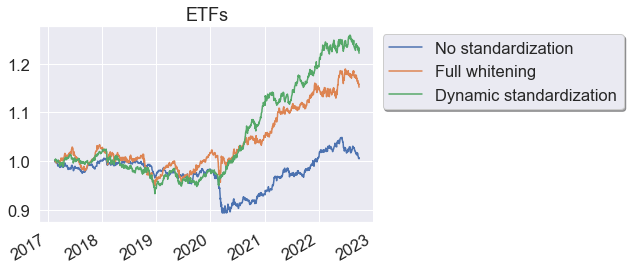

In [43]:
benchmark_portfolios = { "No standardization": trader_nw,
"Full whitening": trader_full}
trader_tripple.show_performance(benchmarks=benchmark_portfolios, label="Dynamic standardization", title="ETFs")

In [ ]:
print("EWMA benchmark"); trader_EWMA.get_metrics()
print("\nNo standardization"); trader_nw.get_metrics()
print("\nRegular standardization"); trader_std.get_metrics()
print("\nDynamic standardization"); trader_full.get_metrics()
print("\nTripple standardization"); trader_tripple.get_metrics()

In [49]:
print("EWMA benchmark"); trader_EWMA.get_metrics()
print("\nNo standardization"); trader_nw.get_metrics()
print("\nRegular standardization"); trader_std.get_metrics()
print("\nDynamic standardization"); trader_full.get_metrics()
print("\nTripple standardization"); trader_tripple.get_metrics()

EWMA benchmark
Mean yearly return (portfolio): 2.74%
Yearly risk (portfolio): 6.47%
Sharpe ratio: 0.42

No standardization
Mean yearly return (portfolio): 5.27%
Yearly risk (portfolio): 6.63%
Sharpe ratio: 0.79

Regular standardization
Mean yearly return (portfolio): 3.43%
Yearly risk (portfolio): 7.14%
Sharpe ratio: 0.48

Dynamic standardization
Mean yearly return (portfolio): 5.26%
Yearly risk (portfolio): 4.58%
Sharpe ratio: 1.1

Tripple standardization
Mean yearly return (portfolio): 4.83%
Yearly risk (portfolio): 4.48%
Sharpe ratio: 1.1


Mean yearly return (portfolio): 4.83%
Yearly risk (portfolio): 4.48%
Sharpe ratio:  1.08


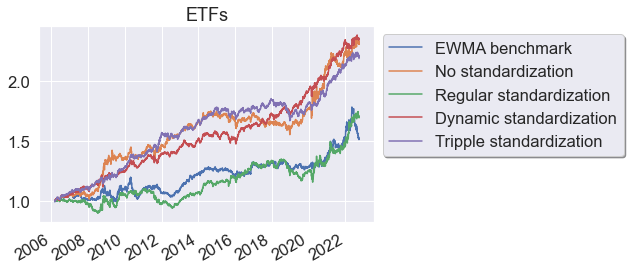

In [52]:
benchmark_portfolios = {"EWMA benchmark": trader_EWMA, "No standardization": trader_nw, "Regular standardization": trader_std\
    , "Dynamic standardization": trader_full}
trader_tripple.show_performance(benchmarks=benchmark_portfolios, label="Tripple standardization", title="ETFs")

In [24]:
r_tildes_var.shape

(14615, 5)

In [25]:
r_tildes_full.shape

(14615, 5)

In [74]:
trader_full.fails

0

Mean yearly return (portfolio): 5.26%
Yearly risk (portfolio): 4.54%
Sharpe ratio:  1.16


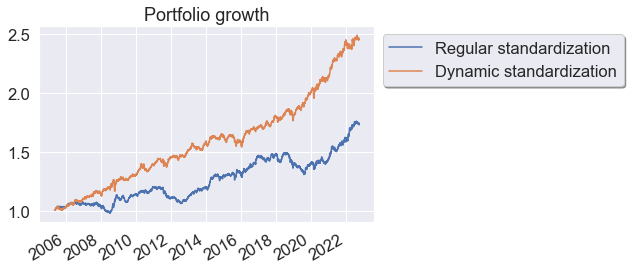

In [80]:
benchmark_portfolios = {"Regular standardization": trader_std}
trader_full.show_performance(benchmarks=benchmark_portfolios, label="Dynamic standardization", title="Portfolio growth")